# Modelling

Glenn Louis Opitz, Alexandre Violleau

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

#sns.set_theme()

In [2]:
data = pd.read_parquet(Path("data") / "train_processed.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,year,month,day,weekday,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,18


### Extract x and y variable (adjusted utils code)

In [3]:

def get_cv(X, y, random_state=0):
    cv = TimeSeriesSplit(n_splits=8)
    rng = np.random.RandomState(random_state)

    for train_idx, test_idx in cv.split(X):
        # Take a random sampling on test_idx so it's that samples are not consecutives.
        yield train_idx, rng.choice(test_idx, size=len(test_idx) // 3, replace=False)


def get_train_data(path="data/train_processed.parquet", _target_column_name = "log_bike_count"):
    data = pd.read_parquet(path)
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [4]:
X, y = get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,year,month,day,weekday,hour
170135,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,1
177599,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,NaN,NaN,NaN,NaN,NaN,2020,9,1,1,1


In [5]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

In [6]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [7]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


### Linear model with all columns (including weather data)

In [8]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [9]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numerical_encoder = make_pipeline(
    SimpleImputer(strategy="mean"),  # Replace NaNs of weather data with the mean 
    StandardScaler())
numerical_corr_cols = ["u", "t", "tx12", "tn12", "rafper", "td", "raf10", "ff", "nnuage3", "vv"] # Weather columns with correlation >|0.1| (see EDA)

binary_cols = ["weekend", "FR_holidays"] # No transformation required, they are already binary

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000002496329B380>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['u', 't', 'tx12', 'tn12',
                                                   'rafper', 'td', 'raf10',
                                                   'ff', 'nnuage3', 'vv']),
                                                 ('binary', 'passthrough',
                                                  ['weekend',
                                                   'FR_holidays'])])),
                ('ridge', Ridge())])

In [10]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.79
Valid set, RMSE=0.74


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

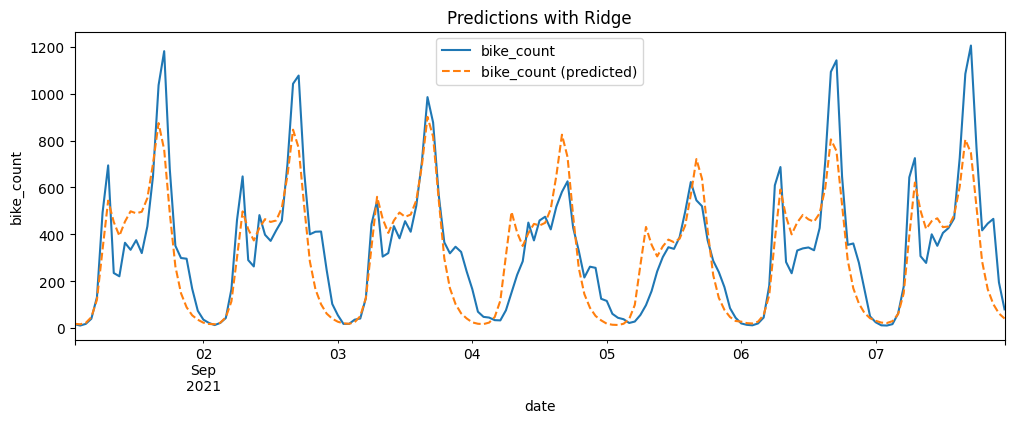

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.92206651 -0.84697604 -0.85504505 -0.85183707 -1.00669547 -0.9103859 ]
RMSE (all folds): 0.899 ± 0.0565


In [15]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha tuning
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

# Perform GridSearchCV
grid = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=6))
grid.fit(X_train, y_train)

# Output the results
print(f"Best alpha: {grid.best_params_['ridge__alpha']}")
print(f"Best RMSE: {-grid.best_score_:.3f}")

# Output RMSE for all alpha values
print("All RMSEs:")
for mean, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
    print(f"alpha: {params['ridge__alpha']}, RMSE: {-mean:.3f}")


Best alpha: 100
Best RMSE: 0.898
All RMSEs:
alpha: 0.01, RMSE: 0.899
alpha: 0.1, RMSE: 0.899
alpha: 1, RMSE: 0.899
alpha: 10, RMSE: 0.899
alpha: 100, RMSE: 0.898


The different Alphas do not really make a difference.

## Decision Tree

In [28]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
date_cols = [col for col in date_cols if col != "day"] # excude day in one hot encoding


categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numerical_encoder = make_pipeline(
    SimpleImputer(strategy="mean"),  # Replace NaNs of weather data with the mean 
    StandardScaler())
numerical_corr_cols = ["u", "t", "tx12", "tn12", "rafper", "td", "raf10", "ff", "nnuage3", "vv"] # Weather columns with correlation >|0.1| (see EDA)

binary_cols = ["weekend", "FR_holidays"] # No transformation required, they are already binary


In [42]:
from sklearn.tree import DecisionTreeRegressor
from time import time

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)

preprocessed_data = preprocessor.fit_transform(X_train)
print(f"Shape of preprocessed data: {preprocessed_data.shape}")

regressor = DecisionTreeRegressor(random_state=42, max_depth=15)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
start = time()
pipe.fit(X_train, y_train)
elapsed_time = time() - start

# Output the result
print(f"Training time for one decision tree: {elapsed_time:.2f} seconds")

# Estimate time for a Random Forest with 100 trees
n_estimators = 100  # Default number of trees in RandomForestRegressor
estimated_forest_time = n_estimators * elapsed_time
print(f"Estimated training time for a Random Forest with {n_estimators} trees: {estimated_forest_time / 60:.2f} minutes")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Shape of preprocessed data: (456507, 133)
Training time for one decision tree: 6.20 seconds
Estimated training time for a Random Forest with 100 trees: 10.33 minutes
Train set, RMSE=0.89
Valid set, RMSE=0.79


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)

preprocessed_data = preprocessor.fit_transform(X_train)
print(f"Shape of preprocessed data: {preprocessed_data.shape}")

regressor = DecisionTreeRegressor(random_state=42, max_depth=15)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
start = time()
pipe.fit(X_train, y_train)
elapsed_time = time() - start

# Output the result
print(f"Training time for one decision tree: {elapsed_time:.2f} seconds")

# Estimate time for a Random Forest with 100 trees
n_estimators = 100  # Default number of trees in RandomForestRegressor
estimated_forest_time = n_estimators * elapsed_time
print(f"Estimated training time for a Random Forest with {n_estimators} trees: {estimated_forest_time / 60:.2f} minutes")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Shape of preprocessed data: (456507, 143)
Training time for one decision tree: 30.18 seconds
Estimated training time for a Random Forest with 100 trees: 50.29 minutes
Train set, RMSE=0.83
Valid set, RMSE=0.80


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The numerical columns (weather data) does improve train RMSE but not really valid RMSE.

### Hyperparameter Tuning

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from time import time

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)

preprocessed_data = preprocessor.fit_transform(X_train)
print(f"Shape of preprocessed data: {preprocessed_data.shape}")

regressor = DecisionTreeRegressor(random_state=42, max_depth=None)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
start = time()
pipe.fit(X_train, y_train)
elapsed_time = time() - start

# Output the result
print(f"Training time for one decision tree: {elapsed_time:.2f} seconds")

# Estimate time for a Random Forest with 100 trees
n_estimators = 100  # Default number of trees in RandomForestRegressor
estimated_forest_time = n_estimators * elapsed_time
print(f"Estimated training time for a Random Forest with {n_estimators} trees: {estimated_forest_time / 60:.2f} minutes")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Shape of preprocessed data: (456507, 133)
Training time for one decision tree: 86.50 seconds
Estimated training time for a Random Forest with 100 trees: 144.16 minutes
Train set, RMSE=0.42
Valid set, RMSE=0.49


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

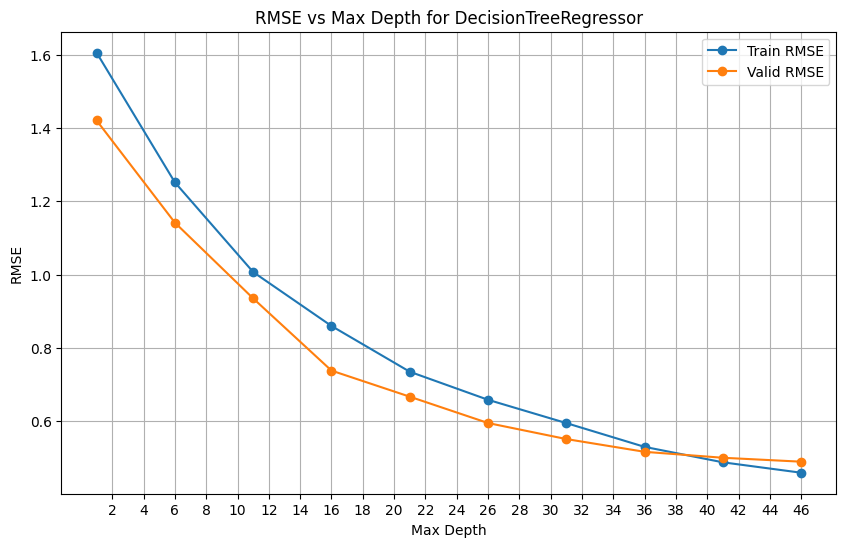

In [43]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)



max_depth_values = range(1, 51, 5)  # Try depths from 1 to 20

train_rmse = []
valid_rmse = []

for max_depth in max_depth_values:
    
    regressor = DecisionTreeRegressor(random_state=42, max_depth=max_depth)

    pipe = make_pipeline(date_encoder, preprocessor, regressor)
    pipe.fit(X_train, y_train)

    rmse_train = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
    train_rmse.append(rmse_train)

    rmse_valid = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)
    valid_rmse.append(rmse_valid)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_rmse, label="Train RMSE", marker="o")
plt.plot(max_depth_values, valid_rmse, label="Valid RMSE", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.title("RMSE vs Max Depth for DecisionTreeRegressor")
plt.legend()
plt.grid(True)

plt.xticks(range(2, max(max_depth_values) + 1, 2))

plt.show()

Presumably, a `max_depth` of `36` minimizes train and valid RMSE the best. This will now also be tested via cross validation.

In [44]:
cv = TimeSeriesSplit(n_splits=6)

regressor = DecisionTreeRegressor(random_state=42, max_depth=36)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.91365729 -0.7982118  -0.68535243 -0.81487141 -0.992582   -1.01080695]
RMSE (all folds): 0.869 ± 0.115


With cross-validation, the decision tree model does not perform significantly better than the ridge analysis.

Let us see the predictionts of `max_depth = 36` for an examplary week


In [45]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("num", numerical_encoder, numerical_corr_cols),
        ("binary", "passthrough", binary_cols)
    ]
)

preprocessed_data = preprocessor.fit_transform(X_train)
print(f"Shape of preprocessed data: {preprocessed_data.shape}")

regressor = DecisionTreeRegressor(random_state=42, max_depth=36)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
start = time()
pipe.fit(X_train, y_train)
elapsed_time = time() - start

# Output the result
print(f"Training time for one decision tree: {elapsed_time:.2f} seconds")

# Estimate time for a Random Forest with 100 trees
n_estimators = 100  # Default number of trees in RandomForestRegressor
estimated_forest_time = n_estimators * elapsed_time
print(f"Estimated training time for a Random Forest with {n_estimators} trees: {estimated_forest_time / 60:.2f} minutes")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Shape of preprocessed data: (456507, 133)
Training time for one decision tree: 37.55 seconds
Estimated training time for a Random Forest with 100 trees: 62.58 minutes
Train set, RMSE=0.53
Valid set, RMSE=0.52


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0, 0.5, 'bike_count')

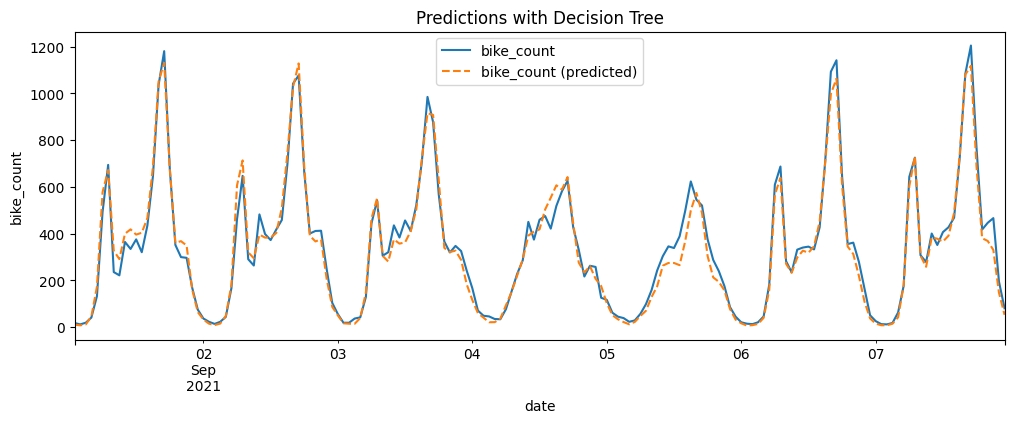

In [47]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Decision Tree")
ax.set_ylabel("bike_count")

During the week, the predictions appear to be very close, while still loosing the edge torwards evenings. On weekeends, the predictions are a bit more off.

## Random Forest

Use the `max_depth = 36` finding for a single tree on Random Forest.

First try for  `n_estimators = 3`:

In [50]:
from sklearn.ensemble import RandomForestRegressor


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        # ("num", numerical_encoder, numerical_corr_cols), 
        ("binary", "passthrough", binary_cols)
    ]
)

regressor = RandomForestRegressor(random_state=42, max_depth=36, n_estimators=3, n_jobs=-1)


start = time()
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start

print(f"Training time for random forest: {elapsed_time:.2f} seconds")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Training time for random forest: 62.78 seconds
Train set, RMSE=0.53
Valid set, RMSE=0.50


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cross validate `n_estimators = 7`:

In [53]:
cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.89882302 -0.77372505 -0.69598279 -0.81155567 -0.99436528 -1.0126501 ]
RMSE (all folds): 0.865 ± 0.115


It is still a bit unclear to me why the CV scores are always higher than the RMSEs for a specific case. Here again, we only have a slight improvement over the Ridge and Decision Tree model. In general, the range is quite high, ranging from RMSE = 1 to RMSE = 0.7.

Final train for  `n_estimators = 7`:

In [65]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        # ("num", numerical_encoder, numerical_corr_cols), 
        ("binary", "passthrough", binary_cols)
    ]
)

regressor = RandomForestRegressor(random_state=42, max_depth=36, n_estimators=7, n_jobs=-1)


start = time()
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)
elapsed_time = time() - start

print(f"Training time for random forest: {elapsed_time:.2f} seconds")

print(f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}")
print(f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}")

Training time for random forest: 124.41 seconds
Train set, RMSE=0.52
Valid set, RMSE=0.49


c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\louis\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Improvements in Train and Valid RMSE in comparison to `n_estimators = 3` are very little. Still, increasing the `n_estimators` might improve robustness.

<Axes: xlabel='y_true', ylabel='y_pred'>

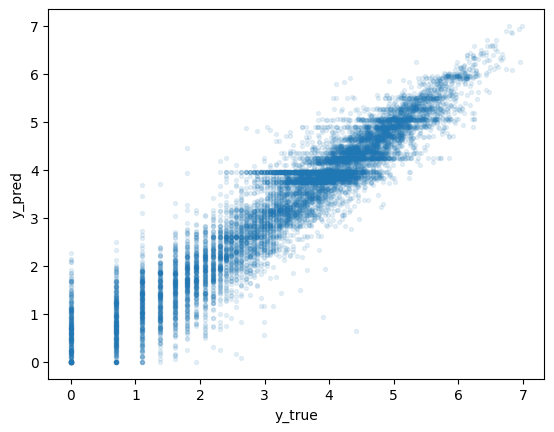

In [66]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

# Apply to test data

In [54]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")

#### Same feature manipulation as for train data (without weather data as not used in final model)

In [55]:
def _encode_dates(X):
    X = X.copy()  # Ensure we're working on a copy
    # Encode the date information
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday  # 0=Monday, 6=Sunday
    X["hour"] = X["date"].dt.hour
    # Keep the rest of the columns as they are
    return X

# Apply the encoding function to the dataset
test_data = test_data.copy()  # Ensure we're working on a copy
test_data = _encode_dates(test_data)

test_data["weekend"] = (test_data["weekday"] > 4).astype(int)  # 1 stands for weekend, 0 stands for no weekend
test_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,year,month,day,weekday,hour,weekend
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,1,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,13,0
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,17,0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,19,0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,22,0


In [61]:
print(f"minimum date: {test_data["date"].min()}")
print(f"maximum date: {test_data["date"].max()}")

minimum date: 2021-09-10 01:00:00
maximum date: 2021-10-18 21:00:00


In [57]:
import holidays

# Define French holidays
FR_holidays = holidays.FR(years=range(2019, 2022))

test_data["FR_holidays"] = test_data["date"].dt.date.isin(FR_holidays).astype(int)
print(f"Number of rows marked as holidays: {test_data['FR_holidays'].sum()}")

Number of rows marked as holidays: 0


#### Run the final model

In [67]:
X_test = test_data

In [69]:
y_pred = pipe.predict(X_test)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission1_Forest,d=36,n=7 .csv", index=False)